In [1]:
# ! pip install kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json # upload key kaggle ke colab

!kaggle datasets download -d misrakahmed/vegetable-image-dataset # download kaggle dataset
!unzip vegetable-image-dataset.zip # unzip dataset

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [2]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed
from tensorflow.keras.preprocessing import image

In [3]:
def training_plot(metrics, history): # make plot for training result
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics): 
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list): # create confusion matrix
    plt.figure(figsize=(15,15))
    y_pred = model.predict(ds) # predict dataset using trained model
    predicted_categories = tf.argmax(y_pred, axis=1) # Returns the index with the largest value across axes of a tensor
    true_categories = tf.concat([y for x, y in ds], axis=0) 
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # calculate confusion matrix
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g') # create heatmap
    plt.show()
    
def testAccuracy(model): #test accuracy
    true_categories = tf.concat([y for x, y in test_ds], axis=0) # create a tensor for storing the true categories from test dataset
    images = tf.concat([x for x, y in test_ds], axis=0) # create a tensor for storing images from test dataset
    y_pred = model.predict(test_ds) # predict image class from test dataset using trained model
    class_names = test_data.class_names # storing class names from test_data
    predicted_categories = tf.argmax(y_pred, axis=1) # storing the highest prediction of categories
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100 # calculate percentage of accuracy score
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names): # make image plot of used image while predicting 
  plt.grid(False)
  plt.xticks([]), plt.yticks([])
  plt.imshow(img, cmap="YlGnBu")
  predicted_label = np.argmax(pred_array)
  if predicted_label == true_label:
    color = 'blue' # if label is true, then give blue color
  else:
    color = 'red'
  plt.xlabel(f"{class_names[predicted_label]} {100*np.max(pred_array):2.0f}% ", color=color) # show predicted class name with the percentage of score

def predictions(model): # to predict random 15 images from test_ds
  true_categories = tf.concat([y for x, y in test_ds], axis=0) # store true categories from test_ds
  images = tf.concat([x for x, y in test_ds], axis=0) # create a tensor for storing images from test_ds
  y_pred = model.predict(test_ds) # predict image from test_ds using trained model
  class_names = test_data.class_names # store classes from the test_data
  indices = random.sample(range(len(images)), 15) # randomly sample 15 test images and plot it with their predicted labels, and the true labels
  # color correct predictions in blue and wrong predictions in red
  num_rows = 3
  num_cols = 5
  num_images = num_rows*num_cols
  plt.figure(figsize=(4*num_cols, 2*num_rows)) # plot predicted images
  for i,index in enumerate(indices):
    plt.subplot(num_rows, num_cols, i+1)
    plot_image(y_pred[index], true_categories[index], images[index],class_names)
  plt.tight_layout()
  plt.show()

def predict_single_image(filename,model): # predict single image
  img_ = image.load_img(filename, target_size=(224, 224)) # resizing image
  img_array = image.img_to_array(img_) # convert image to array
  img_processed = np.expand_dims(img_array, axis=0) # get the expanded dimensions of image array 
  img_processed /= 255. # normalize image array value by 255

  prediction = model.predict(img_processed) # predict image using trained model
  index = np.argmax(prediction) # pick highest number on predicted classes

  # show result
  fig, ax = plt.subplots()
  plt.title(f"Prediction - {test_data.class_names[index]} - {100*np.max(prediction):.2f}%")
  plt.axis('off')
  plt.imshow(img_array)

In [4]:
set_seed(111) # set random seed for reproducible random

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [5]:
class_dirs = os.listdir("Vegetable Images/train") # list all directories inside "train" folder
image_dict = {} # store image array(key) for every class(value)
count_dict = {} # store count of files(key) for every class(value)

for cls in class_dirs: # iterate over all class_dirs
    file_paths = glob.glob(f'Vegetable Images/train/{cls}/*') # get list of all paths inside the subdirectory
    count_dict[cls] = len(file_paths) # count number of files in each class and add it to count_dict
    image_path = random.choice(file_paths) # select random item from list of image paths
    image_dict[cls] = tf.keras.utils.load_img(image_path) # load image using keras utility function and save it in image_dict

# Exploratory Data Analysis

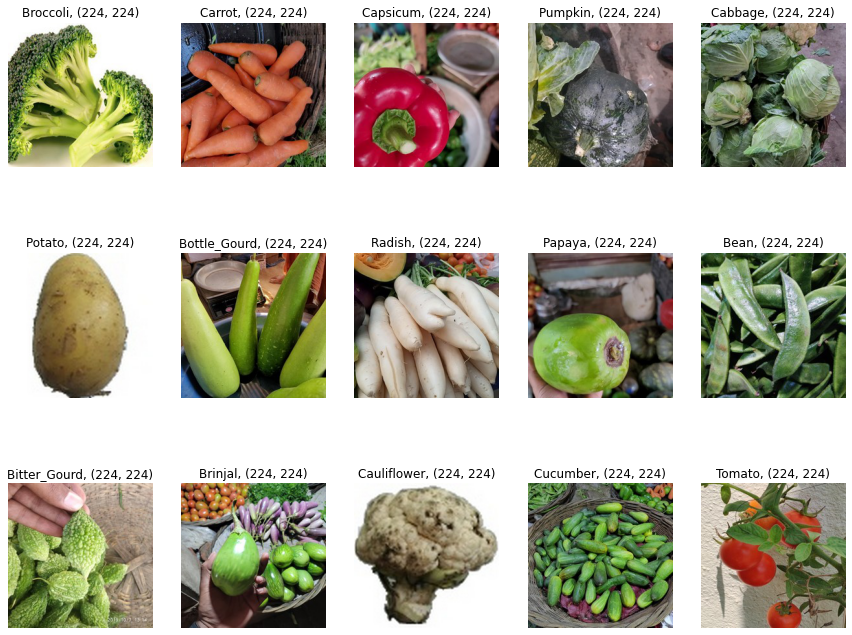

In [6]:
# take random sample from each class
plt.figure(figsize=(15, 12))

for i, (cls,img) in enumerate(image_dict.items()): # iterate over dictionary items (class label, image array)
    # create a subplot axis
    ax = plt.subplot(3, 5, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [7]:
## data distribution of training data across classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(), # keys of count_dict are class labels
    "count": count_dict.values(), # value of count_dict contain counts of each class
})
print("Count of training samples per class:\n", df_count_train)

Count of training samples per class:
            class  count
0       Broccoli   1000
1         Carrot   1000
2       Capsicum   1000
3        Pumpkin   1000
4        Cabbage   1000
5         Potato   1000
6   Bottle_Gourd   1000
7         Radish   1000
8         Papaya   1000
9           Bean   1000
10  Bitter_Gourd   1000
11       Brinjal   1000
12   Cauliflower   1000
13      Cucumber   1000
14        Tomato   1000


<Figure size 1080x864 with 0 Axes>

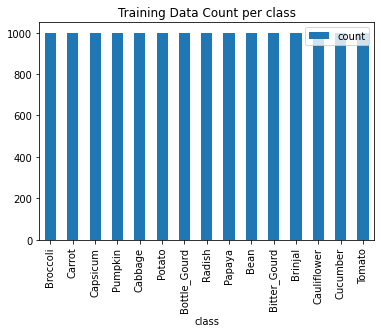

In [8]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Training Data Count per class") 
plt.show()

# Loading data set

In [9]:
print('\nLoading Train Data:')
train_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/train", shuffle = True,
)

print('\nLoading Validation Data:')
val_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/validation", shuffle = False,
)

print('\nLoading Test Data:')
test_data = tf.keras.utils.image_dataset_from_directory(
    "Vegetable Images/test", shuffle = False,
)


Loading Train Data:
Found 15000 files belonging to 15 classes.

Loading Validation Data:
Found 3000 files belonging to 15 classes.

Loading Test Data:
Found 3000 files belonging to 15 classes.


# Data Preprocessing

In [10]:
height, width = 224, 224

# Data processing stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # shape preprocessing
        layers.Rescaling(1.0/255), # value preprocessing to normalize values
    ]
)

# Perform data processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

# MobileNetV2

In [11]:
pretrained_mobilenet_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=[height,width, 3])
pretrained_mobilenet_model.trainable=False
mobilenet_model = tf.keras.Sequential([
    pretrained_mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(15, activation='softmax')
])

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
mobilenet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 15)                19215     
                                                                 
Total params: 2,277,199
Trainable params: 19,215
Non-trainable params: 2,257,984
_________________________________________________________________


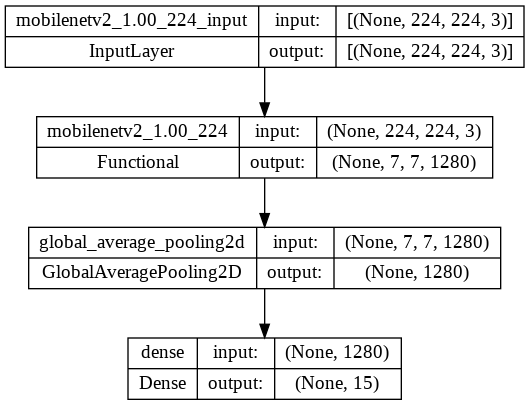

In [14]:
tf.keras.utils.plot_model(mobilenet_model, to_file="mobilenet_model.png", show_shapes=True)

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("mobilenet_model_v2.h5", save_best_only=True) # saves the best last model checkpoint

# stops training after there is no improvement on the validation loss
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

# model fitting
history_mobilenet = mobilenet_model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/20
469/469 [==============================] - 47s 78ms/step - loss: 0.1887 - accuracy: 0.9615 - val_loss: 0.0369 - val_accuracy: 0.9937
Epoch 2/20
469/469 [==============================] - 40s 85ms/step - loss: 0.0247 - accuracy: 0.9968 - val_loss: 0.0185 - val_accuracy: 0.9970
Epoch 3/20
469/469 [==============================] - 35s 73ms/step - loss: 0.0124 - accuracy: 0.9987 - val_loss: 0.0127 - val_accuracy: 0.9977
Epoch 4/20
469/469 [==============================] - 34s 73ms/step - loss: 0.0072 - accuracy: 0.9996 - val_loss: 0.0099 - val_accuracy: 0.9977
Epoch 5/20
469/469 [==============================] - 34s 73ms/step - loss: 0.0046 - accuracy: 0.9999 - val_loss: 0.0086 - val_accuracy: 0.9980
Epoch 6/20
469/469 [==============================] - 34s 72ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 7/20
469/469 [==============================] - 39s 83ms/step - loss: 0.0023 - accuracy: 0.9999 - val_loss: 0.0070 - val_accuracy:

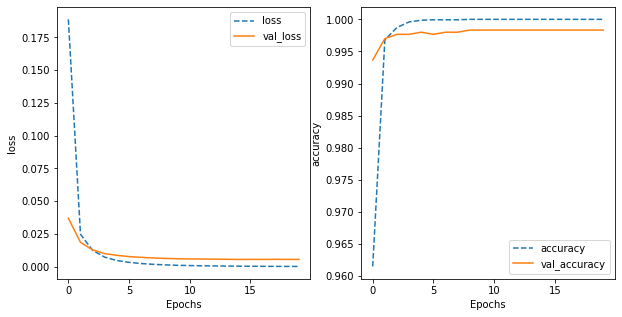

In [16]:
training_plot(['loss', 'accuracy'], history_mobilenet)

In [17]:
testAccuracy(mobilenet_model)

94/94 [==============================] - 7s 69ms/step

Test Accuracy: 99.90%



94/94 [==============================] - 6s 68ms/step


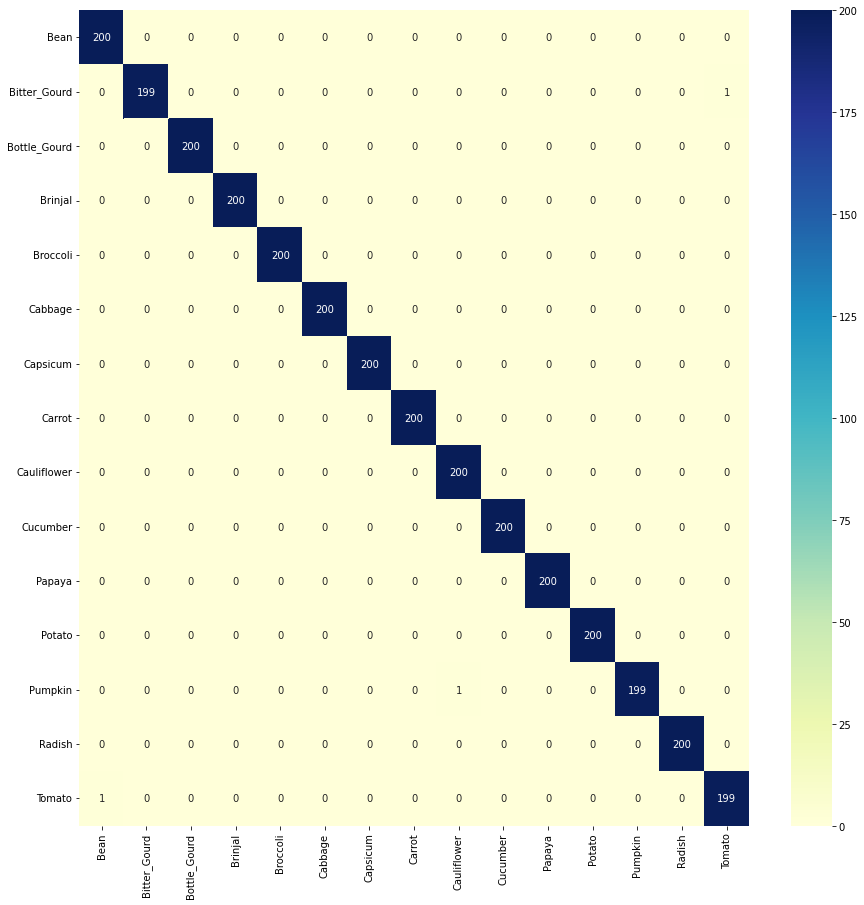

In [18]:
ConfusionMatrix(mobilenet_model, test_ds, test_data.class_names)

# Saving model

In [19]:
# mobilenet_model.save('mobilenet_model_v2.h5')

# Load Model

In [20]:
model = tf.keras.models.load_model('./mobilenet_model_v2.h5')

# Predict image

1/1 [==============================] - 1s 975ms/step


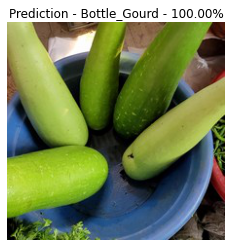

In [21]:
predict_single_image('/content/Vegetable Images/test/Bottle_Gourd/1009.jpg' ,model)

94/94 [==============================] - 7s 68ms/step


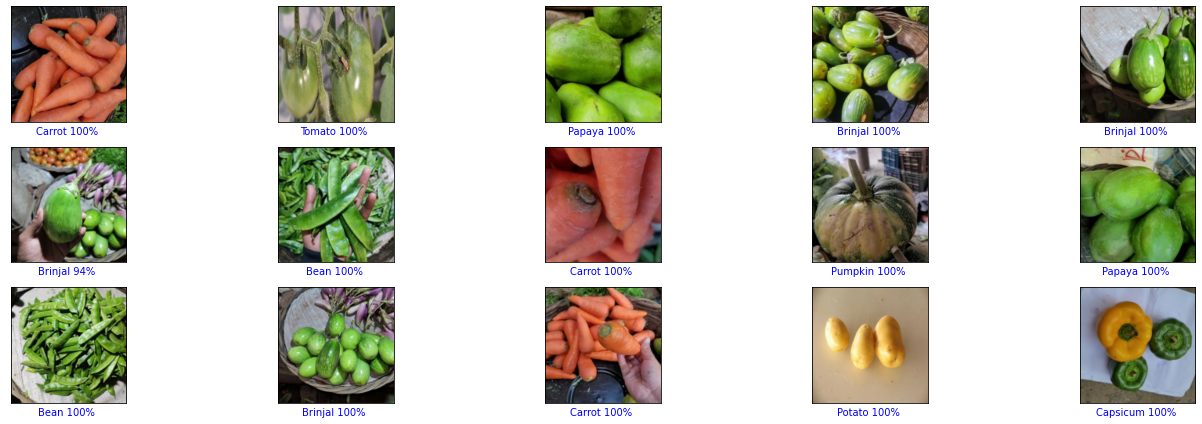

In [22]:
predictions(model)